In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import json
plt.style.use('seaborn')
from sklearn.linear_model import LinearRegression

In [2]:
from scipy.stats import pearsonr, ttest_ind
from statsmodels.stats import weightstats as stests
import folium
from folium.plugins import MarkerCluster, HeatMap

In [3]:
#import data from mongodb
client = pymongo.MongoClient()
db = client.austinhomes
collection = db.clean_home_data
aus_home_df = pd.DataFrame(list(collection.find()))

In [75]:
#view count of samples by source
zillow_df = aus_home_df.query("source == 'zillow'")
realtor_df = aus_home_df.query("source == 'reator'")
austin_realty_df = aus_home_df.query("source == 'austin_realty'")

austin_realty    2738
reator           1608
zillow            534
Name: source, dtype: int64

In [44]:
print('Austin Realty Count: {:,.0f}'.format(len(austin_realty_df)))
print('Realtor Count: {:,.0f}'.format(len(realtor_df)))
print('Zillow Count: {:,.0f}'.format(len(zillow_df)))

Austin Realty Count: 2,791
Realtor Count: 1,714
Zillow Count: 2,143


In [4]:
#dropping all duplicates listings from the different websites (zillow, realtor, austin realty)
aus_home_df['address'] = aus_home_df['address'].apply(lambda x: x.lower())
#assigned to new dataframe
working_df = aus_home_df.drop_duplicates('address')

In [5]:
#overview analysis 
working_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4920 entries, 0 to 6645
Data columns (total 12 columns):
_id          4920 non-null object
address      4920 non-null object
baths        4920 non-null float64
beds         4917 non-null float64
cost         4920 non-null float64
sq_ft        4920 non-null float64
data_type    4920 non-null object
city         4920 non-null object
zip          4920 non-null int64
source       4920 non-null object
lat          4920 non-null float64
lon          4920 non-null float64
dtypes: float64(6), int64(1), object(5)
memory usage: 499.7+ KB


In [6]:
#inspect missing data
working_df.query("beds == 'nan'")

,_id,address,baths,beds,cost,sq_ft,data_type,city,zip,source,lat,lon
1451,5e1509d3708b1eed4f3b9f7e,44 east ave #2206,1.0,NaN,330000.0,481.0,Residential,Austin,78701,austin_realty,30.256205,-97.738787
1803,5e1509d3708b1eed4f3ba0e1,2213 poquito st #115,1.0,NaN,175000.0,407.0,Residential,Austin,78722,austin_realty,30.283748,-97.720670
2585,5e1509d4708b1eed4f3ba3f0,1600 barton springs rd #5208,1.0,NaN,400000.0,743.0,Residential,Austin,78704,austin_realty,30.263106,-97.760989


In [7]:
#updated missing data values 
working_df.loc[:,'beds'].fillna(0, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [8]:
#viewed type of home in my dataframe
working_df['data_type'].value_counts()

Residential                  2738
House for Sale               1252
House for sale                367
Condo/Townhome                331
Condo for sale                107
For sale by owner              36
Mfd/Mobile Home                29
Multi-Family Home              25
Coming soon                    15
Pre-foreclosure / Auction       7
Townhouse for sale              7
Home for sale                   2
Auction                         2
Apartment for sale              1
Foreclosure                     1
Name: data_type, dtype: int64

In [9]:
working_df.describe()

,baths,beds,cost,sq_ft,zip,lat,lon
count,4920.000000,4920.000000,4.920000e+03,4920.000000,4920.000000,4920.000000,4920.000000
mean,2.791463,3.251220,6.847894e+05,2242.950610,78731.714228,30.288045,-97.782459
std,1.246466,1.129138,1.003589e+06,1401.570268,19.190564,0.085910,0.101221
min,1.000000,0.000000,3.000000e+04,289.000000,78652.000000,30.104571,-98.050622
25%,2.000000,3.000000,3.224750e+05,1373.750000,78721.000000,30.226018,-97.836209
50%,3.000000,3.000000,4.405000e+05,1927.000000,78737.000000,30.280400,-97.760356
75%,3.000000,4.000000,6.550000e+05,2744.000000,78746.000000,30.347210,-97.718291
max,13.000000,24.000000,3.500000e+07,20708.000000,78759.000000,30.520579,-97.521809


In [10]:
#filtered out data, not corresponding the statistical test of equal-ratio v unequal-ratio homes
w_df = working_df.query("data_type != ['Foreclosure', 'Apartment for sale', 'Auction', 'Pre-foreclosure / Auction','Mfd/Mobile Home']" )
w_df.loc[:,'zip'] = w_df.loc[:,'zip'].astype('category')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
w_df.describe()

,baths,beds,cost,sq_ft,lat,lon
count,4880.000000,4880.000000,4.880000e+03,4880.000000,4880.000000,4880.000000
mean,2.796824,3.250615,6.887889e+05,2248.567008,30.287762,-97.782914
std,1.248307,1.132220,1.006571e+06,1405.514953,0.085853,0.101050
min,1.000000,0.000000,3.000000e+04,289.000000,30.104571,-98.050622
25%,2.000000,3.000000,3.249000e+05,1375.000000,30.225988,-97.836401
50%,3.000000,3.000000,4.459525e+05,1931.000000,30.280030,-97.760367
75%,3.000000,4.000000,6.610000e+05,2763.000000,30.346886,-97.718804
max,13.000000,24.000000,3.500000e+07,20708.000000,30.520579,-97.521809


In [82]:
w_df['source'].value_counts()

austin_realty    2738
reator           1608
zillow            534
Name: source, dtype: int64

In [12]:
def central_tendency_by(attr, data, sort='count', asc=False): 
    '''
    Groups data by the attribute chosen and generates central tendency outputs of cost, beds,
    baths, and sq_ft.
    
    Parameters:
    -----------
    attr (str): Attribute to be grouped by
    data (dataframe): Dataframe to be analyzed 
    sort (str): Sigle or list of attributes to be sorted by, optional
    asc (bool): True or False, optional
    
    Returns:
    --------
    Series or DataFrame:
        Summary statistics median, mean, count, mean_beds, mean_baths, mean_sqft.  
    '''
    
    grouped = data.groupby(str(attr))
    ct = pd.DataFrame({'median':grouped['cost'].median().apply(lambda x : "{:,.2f}".format(x)),
                           'mean':grouped['cost'].mean().apply(lambda x : "{:,.2f}".format(x)),
                           'count':grouped['cost'].count(),
                            'mean_beds':grouped['beds'].mean().apply(lambda x: "{:1.0f}".format(x)),
                            'mean_baths':grouped['baths'].mean().apply(lambda x: "{:1.0f}".format(x)),
                            'mean_sqft':round(grouped['sq_ft'].mean())
                           })
    return ct.sort_values(sort, ascending=asc)

In [13]:
grp_zip_df = central_tendency_by('zip', w_df)
grp_zip_df.head()

,median,mean,count,mean_beds,mean_baths,mean_sqft
zip,,,,,,
78704,"715,000.00","889,501.39",355,3,3,1893.0
78745,"361,425.00","388,753.95",275,3,2,1517.0
78737,"527,990.00","614,659.86",259,4,3,3150.0
78738,"612,900.00","793,224.55",256,4,4,3485.0
78748,"315,000.00","327,912.17",213,3,3,1952.0


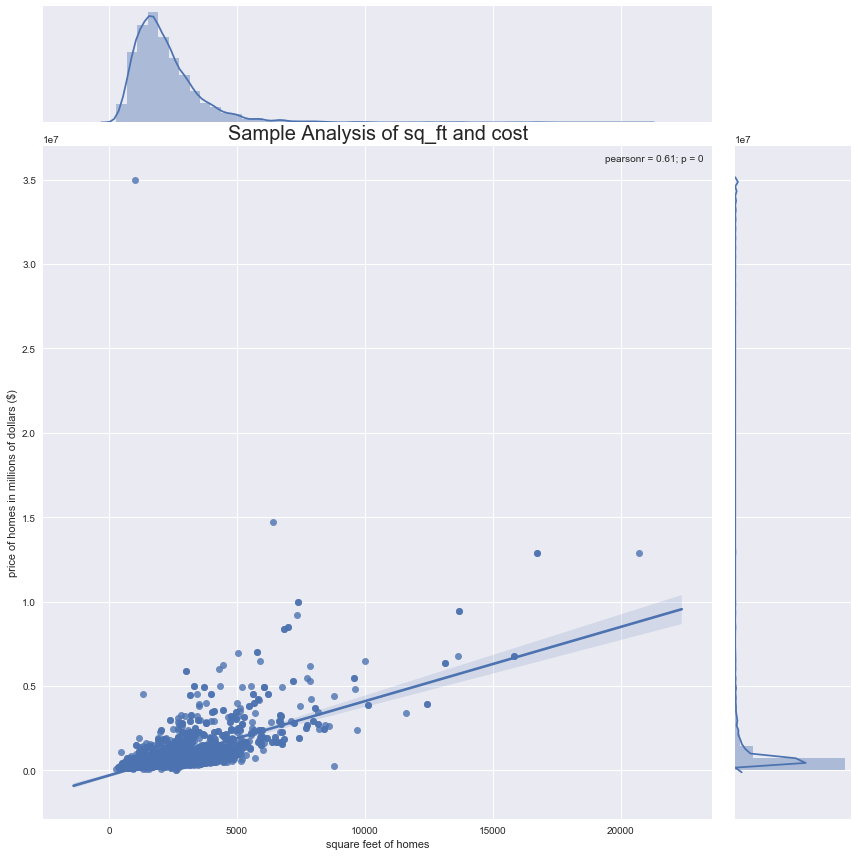

In [39]:
#scatter plot with and pearsonr correlation between square feet and value of home
def plot_jointplot(data, x='sq_ft', y='cost', kind='reg', height=12, yunit='thousands'):
    '''
    Creates joint plot with histogram, distribution, scatter plot, and provides a pearsonr line
    
    Parameters:
    -----------
    data (dataframe): data to be used for plotting
    x (str): series for the x-axis, set to 'sq_ft'
    y (str): series for the y-axis, set to 'cost'
    kind: set to 'reg'
    height: set to 12
    yunit: set to 'thousands'
    
    Returns:
    --------
    Returns a seaborn jointplot graph 
    '''
    sns.jointplot(x=x, y=y, kind=kind, data=data, height=(height), stat_func=pearsonr)
    plt.ylabel(f'price of homes in {yunit} of dollars ($)')
    plt.xlabel('square feet of homes')
    plt.title('Sample Analysis of {} and {}'.format(x, y), fontsize=20)
    plt.savefig('images/jointplot.png')
    return plt.show()


plot_jointplot(w_df, yunit='millions')

In [40]:
#derive outliers for any particular parameter
def outliers(data, column):
    '''
    Derives the interquartile range (IQR) for a dataset parameter. And 
    
    Parameters:
    -----------
    data (dataframe): Dataframe to be analyzed
    column (str): Name of parameter (column) for quantile analysis 
    
    Returns:
    --------
    Two values (int): upper and lower outlier limits. 
    '''
    
    Q1_cost = data[str(column)].quantile(.25) 
    Q3_cost = data[str(column)].quantile(.75) 
    
    IQR = Q3_cost - Q1_cost
    
    upper_limit_outlier = Q3_cost + (1.5*IQR)
    lower_limit_outlier = Q1_cost - (1.5*IQR)
    return upper_limit_outlier, lower_limit_outlier

In [41]:
#derived outlier limits
cost_ol = outliers(w_df, 'cost')
sqft_ol = outliers(w_df, 'sq_ft')
print(cost_ol, sqft_ol)

(1165150.0, -179250.0) (4845.0, -707.0)


In [42]:
#removed outliers
mod_df = w_df.query("cost < 1165150.0 and sq_ft < 4845.0")
mod_df.describe()

,baths,beds,cost,sq_ft,lat,lon
count,4318.000000,4318.000000,4.318000e+03,4318.000000,4318.000000,4318.000000
mean,2.547013,3.107689,4.583841e+05,1948.259843,30.286164,-97.778967
std,0.886540,0.982464,2.000344e+05,863.678528,0.088645,0.102578
min,1.000000,0.000000,3.000000e+04,289.000000,30.104571,-98.050622
25%,2.000000,3.000000,3.100000e+05,1300.000000,30.218015,-97.830169
50%,2.500000,3.000000,4.170000e+05,1800.000000,30.278031,-97.757000
75%,3.000000,4.000000,5.650000e+05,2450.000000,30.350387,-97.713770
max,7.000000,8.000000,1.150000e+06,4841.000000,30.520579,-97.521809


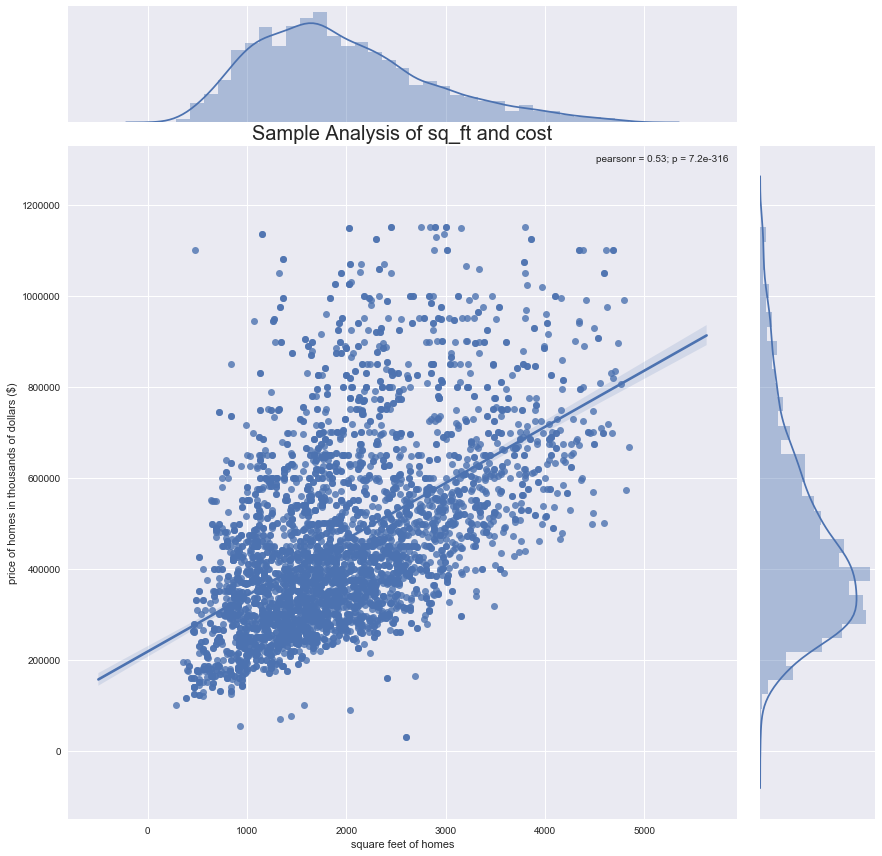

In [43]:
#scatter plot with and pearsonr correlation between square feet and value of home
plot_jointplot(mod_df)

### Is there a statistically significant difference in the value of homes between equal bed-to-bath ratio vs unequal ratio homes.
Ho: mean of two groups is 0<br>
H1: mean of two groups is not 0 

Ho: The null hypothesis is that the ratio of bedroom to bathroom ratio has not affect on the mean value of a home.<br> 
H1: The alternative hypothesis is that the ration of the home has an affect.

In [102]:
#splitting data without outliers
equal_ratio = mod_df.query("beds == baths")
unequal_ratio = mod_df.query("beds != baths")

#splitting data with outliers
org_equal_ratio = w_df.query("beds == baths")
org_unequal_ratio = w_df.query("beds != baths")

print("Original Data Equal-Ratio v Unequal-Ratio Avg Home Value: {:,.0f} | {:,.0f}"
      .format(np.mean(org_equal_ratio['cost']), np.mean(org_unequal_ratio['cost'])))
print("Adjusted Data Equal-Ratio v Unequal-Ratio Avg Home Value: {:,.0f} | {:,.0f}"
      .format(np.mean(equal_ratio['cost']), np.mean(unequal_ratio['cost'])))
print("Adjusted Equal count: {:,.0f} | Adjusted Unequal Count: {:,.0f}".format(len(equal_ratio), len(unequal_ratio)))
print("Average difference of: {:,.0f}".format(np.mean(equal_ratio['cost'])-np.mean(unequal_ratio['cost'])))

Original Data Equal-Ratio v Unequal-Ratio Avg Home Value: 634,529 | 715,380
Adjusted Data Equal-Ratio v Unequal-Ratio Avg Home Value: 473,059 | 451,164
Adjusted Equal count: 1,424 | Adjusted Unequal Count: 2,894
Average difference of: 21,895


In [101]:
print("Total Sample Square Feet Mean: {:,.0f}".format(round(np.mean(mod_df['sq_ft'])))) 
print("Equal Ratio Square Feet Mean: {:,.0f}".format(round(np.mean(equal_ratio['sq_ft'])))) 
print("Unequal Ratio Square Feet Mean: {:,.0f}".format(round(np.mean(unequal_ratio['sq_ft']))))

Total Sample Square Feet Mean: 1,948
Equal Ratio Square Feet Mean: 1,796
Unequal Ratio Square Feet Mean: 2,023


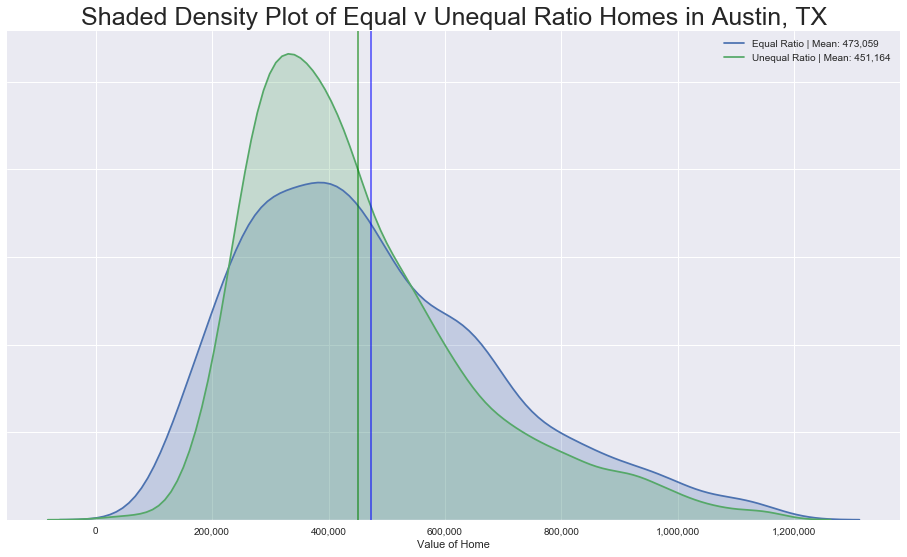

In [124]:
#distributions of equal and unequal samples
fig, ax = plt.subplots(figsize=(16,9))
ax_eq =sns.kdeplot(equal_ratio['cost'], shade=True, label='Equal Ratio | Mean: {:5,.0f}'.format(np.mean(equal_ratio['cost'])))
ax_un =sns.kdeplot(unequal_ratio['cost'], shade=True, label='Unequal Ratio | Mean: {:5,.0f}'.format(np.mean(unequal_ratio['cost'])))

#plotting averages of samples
ax_eq.axvline(np.mean(equal_ratio['cost']), color='blue',alpha=0.6)
ax_un.axvline(np.mean(unequal_ratio['cost']), color='green', alpha=0.6)

ax.set_xlabel('Value of Home')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter(''))
plt.title('Shaded Density Plot of Equal v Unequal Ratio Homes in Austin, TX', fontsize=25)
plt.savefig('images/distributions.png')
plt.show()

### Why use a z-test

A z-test is a statistical test used to determine whether two population means are different when the variances are known and the sample size is large. 

1) Your sample size is > 30<br>
2) Data points should be independent from each other<br>
3) It can be used to test hypotheses in which the z-test follows a normal distribution<br>
4) Data needs to be randomly selected from the population, where each item has an equal chance of being selected<br>
5) A z-statistic, or z-score, is a number representing the result from the z-test



In [21]:
#z-test analysis
ztest, pval = stests.ztest(equal_ratio['cost'], unequal_ratio['cost'])

if pval < 0.05:
    print('The p-value of {:2.3f} is smaller than 0.05 we reject null hypothesis'.format(pval))
else:
    print('The p-value of {:2.3f} is greater than 0.05 so we fail to reject the null hypothesis'.format(pval))
    
print('z-test: {:2.3f}, p-value: {:2.3f}'.format(ztest,pval))

The p-value of 0.001 is smaller than 0.05 we reject null hypothesis
z-test: 3.386, p-value: 0.001


There is enough data to deduce that equal ratio homes tend to be worth more than unequal ratio homes by an average of $22,000.  

In [22]:
mlr = LinearRegression()

X, y = mod_df[['beds', 'baths', 'sq_ft']], mod_df['cost']
mlr.fit(X,y)

#difference between y to the mean of y
yhat=mlr.predict(X)
SS_Residual= sum((y-yhat)**2)

#sum of square total: measurment of total variability in variable y
SS_Total = sum((y-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1-(1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)

print("R^2: {:2.2f}, Adj_R^2: {:2.2f}".format(r_squared,adjusted_r_squared))

R^2: 0.31, Adj_R^2: 0.31


In [23]:
mlr = LinearRegression()

#created dummie variables for zipcodes
test_df = pd.get_dummies(mod_df, columns=['zip'], drop_first=True)

cols = ['_id', 'address', 'cost', 'data_type', 'city', 'source', 'lat', 'lon']
X = test_df.drop(cols, axis=1)
y = test_df['cost']
mlr.fit(X,y)

#difference between y to the mean of y
yhat=mlr.predict(X)
SS_Residual= sum((y-yhat)**2)

#sum of square total: measurment of total variability in variable y
SS_Total = sum((y-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1-(1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)

print("R^2: {:2.2f}, Adj_R^2: {:2.2f}".format(r_squared,adjusted_r_squared))

R^2: 0.69, Adj_R^2: 0.69


In [24]:
corr_matrix = mod_df[['baths', 'beds', 'cost', 'sq_ft']].corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,baths,beds,cost,sq_ft
baths,1,0.643641,0.46997,0.768284
beds,0.643641,1,0.33075,0.745301
cost,0.46997,0.33075,1,0.533204
sq_ft,0.768284,0.745301,0.533204,1


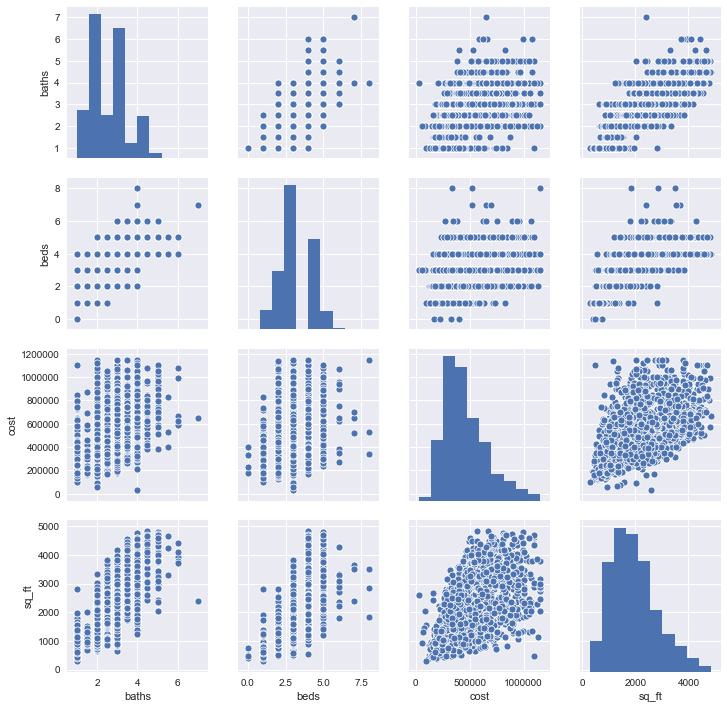

In [54]:
sns.pairplot(mod_df[['baths', 'beds', 'cost', 'sq_ft']])
plt.savefig('images/correlation_plots.png')
plt.show()

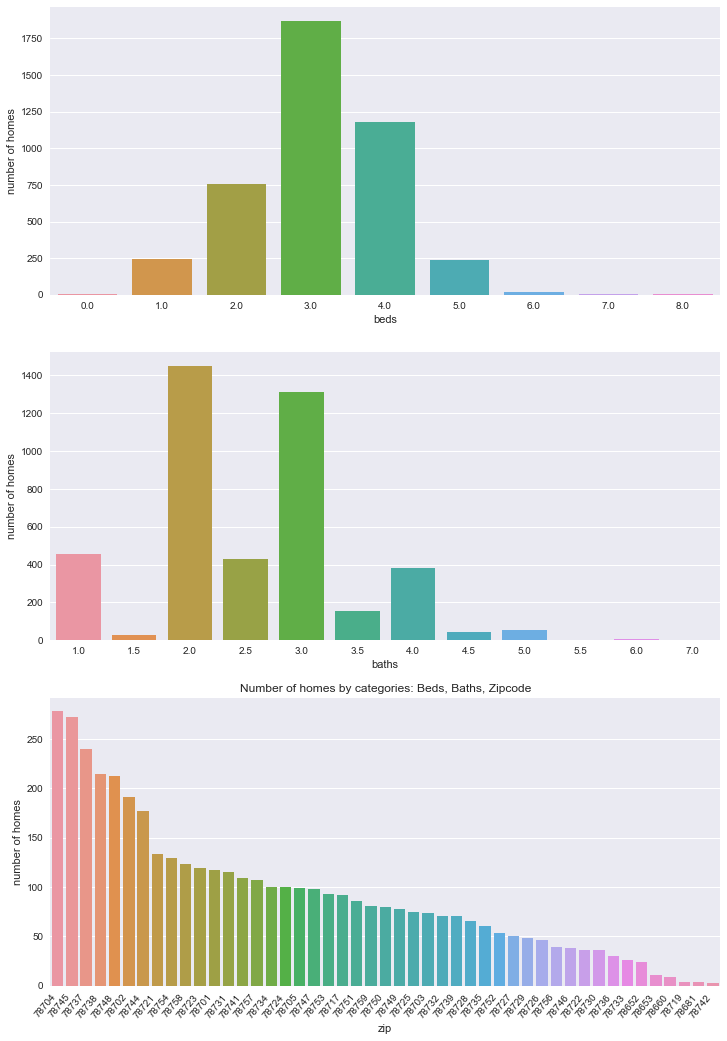

In [60]:
#displaying bed, bath, and zip counts within my sample
fig, ax = plt.subplots(3,1, figsize=(12,18))
sns.countplot(mod_df['beds'], ax=ax[0])
sns.countplot(mod_df['baths'], ax=ax[1])
sns.countplot(mod_df['zip'], ax=ax[2], order = mod_df['zip'].value_counts().index)
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=50, ha="right")

plt.title('Number of homes by categories: Beds, Baths, Zipcode')
ax[0].set_ylabel('number of homes')
ax[1].set_ylabel('number of homes')
ax[2].set_ylabel('number of homes')
plt.savefig('images/count_tables.png')
plt.show()

In [27]:
#create a new column with bed and bath to be able to do a groupby base on unique ratios
mod_df.loc[:,'beds_baths'] = mod_df.loc[:,'beds'].map(str) + ' x ' + mod_df.loc[:,'baths'].map(str)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


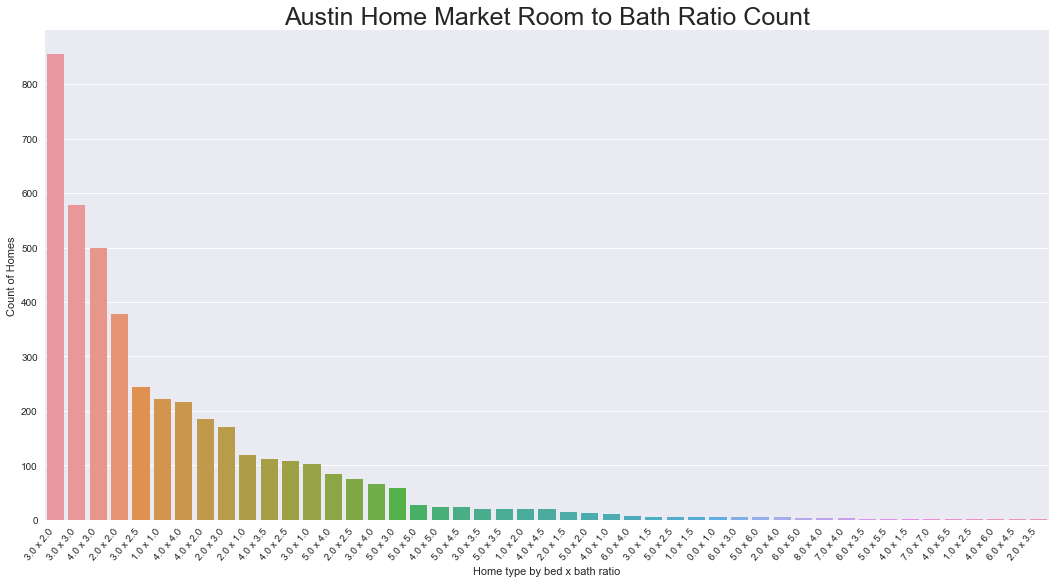

In [28]:
fig, ax = plt.subplots(figsize=(18,9))
sns.countplot(mod_df['beds_baths'], order = mod_df['beds_baths'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.set_title('Austin Home Market Room to Bath Ratio Count', fontsize=25)
ax.set_ylabel('Count of Homes')
ax.set_xlabel('Home type by bed x bath ratio')
plt.show()

In [29]:
beds_bath_df = central_tendency_by('beds_baths', mod_df, sort='count') 
beds_bath_df.head()

,median,mean,count,mean_beds,mean_baths,mean_sqft
beds_baths,,,,,,
3.0 x 2.0,"350,000.00","387,393.61",856,3,2,1605.0
3.0 x 3.0,"439,000.00","485,918.03",579,3,3,1980.0
4.0 x 3.0,"470,648.00","516,129.24",500,4,3,2568.0
2.0 x 2.0,"394,990.00","427,360.04",377,2,2,1184.0
3.0 x 2.5,"384,000.00","417,593.51",243,3,2,2043.0


In [67]:
map_df = mod_df[['cost','source','lat','lon']]
# sub_setmap = map_df.query("source == 'reator'")
sub_setmap = map_df[:2000]
austin_map = folium.Map(location=['30.264980', '-97.746597'], zoom_start =10)

mc = MarkerCluster()

for row in sub_setmap.itertuples():
    mc.add_child(folium.Marker(location=[row.lat,row.lon], popup=[row.cost]))

In [72]:
map_df = mod_df[['cost','source','lat','lon']]
sub_setmap = map_df
austin_map = folium.Map(location=['30.264980', '-97.746597'], zoom_start=11)
HeatMap(data=sub_setmap[['lat', 'lon']].values.tolist(), radius=9, max_zoom=13).add_to(austin_map)
# austin_map
austin_map.add_child(mc)

Limitations:

Square feet only take into account size of the livable space.

Looking forward:

Incorporate 

Methodology:
Data used in the study included square footage, number of beds, baths, and value for all single and multi-family homes, condo, and townhomes with active listings in the Austin housing market from December 2019 to January 2020, inside the city limits.  This data was used to calculate averages and test for significance between equal ratio vs unequal ratio homes. All figures shown in the article represent the mean value for each data point unless otherwise specified. The IQR (interquartile range) method of outlier detection was implemented as part of the data cleansing process. 